### First we need to import all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

### Now the datasets are read and merged into a single dataframe

In [2]:
df_16082023 = pd.read_csv('df_2023-08-16.csv', parse_dates=['date_utc'])
df_17082023 = pd.read_csv('df_2023-08-17.csv', parse_dates=['date_utc'])
df_18082023 = pd.read_csv('df_2023-08-18.csv', parse_dates=['date_utc'])

df = pd.concat([df_16082023, df_17082023, df_18082023], ignore_index=True)
df

,trace_time,cookie_value,query,results,topcategory,id,price,totalprice,popularity,categoryid,...,listedsince,relevance_score,text_relevance,itemtype,date_utc,prev_clicks,prev_impressions,clicks,impressions,relevance_label
0,1692216825804,01j4xv1o00lk2gkf1r,tk-5240k,1377,4995,3509604132933600003,5451,5451,0,4995,...,NaN,28350,37.5,0,2023-08-16,0.0,60.0,0.0,4.0,0.0
1,1692211903439,01na5ol400liq9p3zz,synology ds223j,102,9272,3548574108113437554,49090,49639,0,3751,...,NaN,79380,105.0,0,2023-08-16,0.0,5.0,0.0,4.0,0.0
2,1692211507151,0113m0ic00ky1rmiyw,familyfix 360,110,15592,3530515860405879623,38899,39098,44,5852,...,NaN,45390,50.0,0,2023-08-16,0.0,68.0,0.0,3.0,0.0
3,1692183090078,01fhyzxc00lldl7p0c,snup,64,14173,3470293304510251280,385,385,0,14173,...,NaN,13230,25.0,0,2023-08-16,0.0,74.0,0.0,3.0,0.0
4,1692220521164,01hn0h0000lle7vnfx,air pods 3,59498,2520,6837655,8799,8799,3823,2520,...,1.572304e+12,83590,55.1,3,2023-08-16,3.0,171.0,0.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725284,1692377985834,01yj0h0000llgu1mjo,samsung galaxy tab s8 plus,13181,3747,201871702,87900,87900,27,3747,...,1.647385e+12,191130,155.3,3,2023-08-18,0.0,222.0,0.0,5.0,0.0
725285,1692377985834,01yj0h0000llgu1mjo,samsung galaxy tab s8 plus,13181,3747,202656676,1299,1299,0,22506,...,1.681769e+12,159430,150.5,3,2023-08-18,0.0,68.0,0.0,5.0,0.0
725286,1692397950145,01s1meel00l94omjko,rimowa,110,9113,6319428,118000,118000,15,9113,...,1.537913e+12,48930,42.1,3,2023-08-18,43.0,660.0,1.0,19.0,4.0
725287,1692397950145,01s1meel00l94omjko,rimowa,110,9113,3503362884648304699,114000,114000,6,22655,...,NaN,24180,30.0,0,2023-08-18,0.0,166.0,0.0,16.0,0.0


##### Checking the column names for clarify.

In [3]:
df.columns

Index(['trace_time', 'cookie_value', 'query', 'results', 'topcategory', 'id',
       'price', 'totalprice', 'popularity', 'categoryid', 'manuid', 'shopid',
       'availability', 'rating', 'tests', 'numratings', 'discount',
       'shorttermbargain', 'bargain', 'productscore', 'listedsince',
       'relevance_score', 'text_relevance', 'itemtype', 'date_utc',
       'prev_clicks', 'prev_impressions', 'clicks', 'impressions',
       'relevance_label'],
      dtype='object')

##### Checking what kind of data is stored in the columns. The object columns need to be transformed into numeric columns in order to feed into the model, the NaN values have to be checked (which columns have time, how much and why if possible to answer).
##### We see that only 'cookie_value' and 'query' columns have strings and 'date_utc' column has datetime values.
##### The columns 'relevance_label' and 'listedsince' have significant amount if missing values (NaN), but the 'listedsince' columns is not that relevant to the current task of modeling, while 'relevance_label' is the target value and it is present in 92% of the cases (can be proceeded this way).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725289 entries, 0 to 725288
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   trace_time        725289 non-null  int64         
 1   cookie_value      725289 non-null  object        
 2   query             725289 non-null  object        
 3   results           725289 non-null  int64         
 4   topcategory       725289 non-null  int64         
 5   id                725289 non-null  int64         
 6   price             725289 non-null  int64         
 7   totalprice        725289 non-null  int64         
 8   popularity        725289 non-null  int64         
 9   categoryid        725289 non-null  int64         
 10  manuid            725289 non-null  int64         
 11  shopid            725289 non-null  float64       
 12  availability      725289 non-null  int64         
 13  rating            725289 non-null  float64       
 14  test

##### The following function gives the stats on each column of the dataframe. The minimum, mean, std and maximum values can be seen that helps to understand what kind of information each column stores.

In [5]:
df.describe()

,trace_time,results,topcategory,id,price,totalprice,popularity,categoryid,manuid,shopid,...,listedsince,relevance_score,text_relevance,itemtype,date_utc,prev_clicks,prev_impressions,clicks,impressions,relevance_label
count,7.252890e+05,7.252890e+05,725289.000000,7.252890e+05,7.252890e+05,7.252890e+05,725289.000000,725289.000000,725289.000000,725289.000000,...,4.087340e+05,7.252890e+05,725289.000000,725289.000000,725289,722633.000000,722633.000000,722633.000000,722633.000000,668877.000000
mean,1.692293e+12,1.424473e+05,13470.224488,1.520228e+18,5.657782e+04,5.681189e+04,140.883191,13902.626790,50869.400384,49278.370914,...,1.614864e+12,1.138306e+05,137.845543,1.608586,2023-08-16 23:43:15.895980800,3.340072,305.914319,0.115883,11.716505,0.138949
min,1.692144e+12,1.000000e+00,1002.000000,1.532200e+04,-1.000000e+00,-1.000000e+00,0.000000,1000.000000,0.000000,-1.000000,...,9.923832e+11,1.000000e+01,0.100000,0.000000,2023-08-16 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.692220e+12,1.450000e+02,3706.000000,2.017346e+08,1.790000e+03,2.000000e+03,0.000000,5232.000000,1049.000000,-1.000000,...,1.600639e+12,4.273000e+04,53.100000,0.000000,2023-08-16 00:00:00,0.000000,78.000000,0.000000,3.000000,0.000000
50%,1.692298e+12,8.850000e+02,12021.000000,2.027870e+08,6.299000e+03,6.499000e+03,2.000000,13092.000000,14902.000000,-1.000000,...,1.646867e+12,7.041000e+04,75.200000,2.000000,2023-08-17 00:00:00,0.000000,145.000000,0.000000,5.000000,0.000000
75%,1.692366e+12,1.250000e+04,19116.000000,3.513640e+18,3.599900e+04,3.627100e+04,22.000000,19116.000000,116377.000000,12041.000000,...,1.675897e+12,1.061500e+05,105.000000,3.000000,2023-08-18 00:00:00,0.000000,277.000000,0.000000,11.000000,0.000000
max,1.692403e+12,9.211318e+06,32719.000000,3.549220e+18,1.190000e+09,1.190000e+09,23502.000000,32719.000000,172976.000000,329972.000000,...,1.692310e+12,5.081960e+06,8350.000000,3.000000,2023-08-18 00:00:00,6199.000000,23761.000000,207.000000,720.000000,4.000000
std,7.146754e+07,4.991681e+05,9415.221774,1.735917e+18,3.956166e+06,3.956167e+06,929.811078,9014.140262,62044.239728,107839.799720,...,9.805977e+10,1.939088e+05,228.020116,1.440176,NaN,34.991133,806.650711,1.204796,28.724736,0.671882


### 1. Data Preprocessing

##### There are huge amount of plots and value_counts() that I used to understand what kind of data is present, but I will put them in the end to first concentrate on the model training.

##### In the following cell I am encoding the only 2 object columns with a Label Encoder from sklearn.

In [6]:
le = LabelEncoder()
query_encoded = le.fit_transform(df['query'])
cookie_value_encoded = le.fit_transform(df['cookie_value'])

df['query_encoded'] = query_encoded
df['cookie_value_encoded'] = cookie_value_encoded

encoded_df = df.drop(columns=['query', 'cookie_value'])
encoded_df = encoded_df.fillna(0)
encoded_df

,trace_time,results,topcategory,id,price,totalprice,popularity,categoryid,manuid,shopid,...,text_relevance,itemtype,date_utc,prev_clicks,prev_impressions,clicks,impressions,relevance_label,query_encoded,cookie_value_encoded
0,1692216825804,1377,4995,3509604132933600003,5451,5451,0,4995,0,5300.0,...,37.5,0,2023-08-16,0.0,60.0,0.0,4.0,0.0,5057,6872
1,1692211903439,102,9272,3548574108113437554,49090,49639,0,3751,33280,301558.0,...,105.0,0,2023-08-16,0.0,5.0,0.0,4.0,0.0,4934,8365
2,1692211507151,110,15592,3530515860405879623,38899,39098,44,5852,16600,318806.0,...,50.0,0,2023-08-16,0.0,68.0,0.0,3.0,0.0,1638,367
3,1692183090078,64,14173,3470293304510251280,385,385,0,14173,0,12041.0,...,25.0,0,2023-08-16,0.0,74.0,0.0,3.0,0.0,4697,5538
4,1692220521164,59498,2520,6837655,8799,8799,3823,2520,11880,-1.0,...,55.1,3,2023-08-16,3.0,171.0,0.0,13.0,0.0,333,6324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725284,1692377985834,13181,3747,201871702,87900,87900,27,3747,1049,-1.0,...,155.3,3,2023-08-18,0.0,222.0,0.0,5.0,0.0,4429,12425
725285,1692377985834,13181,3747,202656676,1299,1299,0,22506,169110,-1.0,...,150.5,3,2023-08-18,0.0,68.0,0.0,5.0,0.0,4429,12425
725286,1692397950145,110,9113,6319428,118000,118000,15,9113,2639,-1.0,...,42.1,3,2023-08-18,43.0,660.0,1.0,19.0,4.0,4114,10084
725287,1692397950145,110,9113,3503362884648304699,114000,114000,6,22655,2639,223186.0,...,30.0,0,2023-08-18,0.0,166.0,0.0,16.0,0.0,4114,10084


### 2. Feature Engineering

##### Current task can be tackled by checking the columns  and theoritizing.

##### The theory hereby:
###### Columns to Use as Features:

    'results': The number of results returned by the search query can be a valuable feature as it may indicate the diversity or coverage of results for a query.

    'popularity': Popularity score can provide insight into how frequently an item is viewed or interacted with, which can be relevant for ranking.

    'rating': User ratings of returned items can be important for ranking, as highly-rated items are often considered more relevant.

    'numratings': The number of ratings received by items can be a valuable feature as it indicates the level of user engagement with items.

    'discount': The discount offered on items can influence user preferences and item relevance.

    'productscore': The product score of items might be a measure of item quality or relevance and should be considered.

    'prev_clicks' and 'prev_impressions': These columns represent historical user interactions with items in previous search results and can provide valuable context for ranking.

###### Arguments for Using These Columns as Features:

    These columns contain information directly related to user preferences, item relevance, and interactions, which are critical for ranking.
    They capture various aspects of item popularity, user feedback, and discounts that can impact user choices.
    Historical user interactions provide context for the ranking model to learn from.

###### Columns to Consider for Features:

    'price' and 'totalprice': The price of items is often an important factor in ranking, but it depends on the specific application and user preferences. Consider including them but be aware of potential multicollinearity.

    'availability': The availability of items may influence ranking but might not be as critical in all scenarios.

###### Arguments for Considering These Columns for Features:

    Price and availability can be informative if they are important criteria for user preferences in your domain.

###### Columns to Drop:

    'trace_time' and 'date_utc': These columns represent timestamps and do not directly contribute to item ranking. They are typically used for time-based analysis and may not be useful features for the model.

    'query': The search query itself may be less relevant for ranking as it's more about the user's input than item relevance.

    'cookie_value': A unique identifier for the user's session is not typically used as a feature for ranking items.

    'topcategory', 'id', 'categoryid', 'manuid', 'shopid', 'text_relevance', 'itemtype': These columns may have limited direct relevance to item ranking and should be dropped unless you have specific domain knowledge suggesting their importance.

    'listedsince': The date when the item was listed may not be as relevant for ranking.

###### Arguments for Dropping These Columns:

    These columns do not directly contribute to item relevance or user preferences for ranking.
    Including irrelevant or redundant features can lead to model overfitting and increased complexity.

###### The task can be tackled algorithmically. In this task, I used the RFE model to choose top 5 and 15 columns that affect the dataset the most.

In [7]:
# top 5 features

model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=5, step=1)
X_new = rfe.fit_transform(encoded_df.drop(columns=['date_utc', 'relevance_label', 'relevance_score'], axis=1), encoded_df['relevance_label'])
selected_features = encoded_df.drop(['date_utc', 'relevance_label', 'relevance_score'], axis=1).columns[rfe.support_]
print("Selected columns:")
print(selected_features)

Selected columns:
Index(['popularity', 'prev_clicks', 'prev_impressions', 'clicks',
       'impressions'],
      dtype='object')


In [8]:
# top 15 features

model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=15, step=1)
X_new = rfe.fit_transform(encoded_df.drop(columns=['date_utc', 'relevance_label', 'relevance_score'], axis=1), encoded_df['relevance_label'])
selected_features = encoded_df.drop(['date_utc', 'relevance_label', 'relevance_score'], axis=1).columns[rfe.support_]
print("Selected columns:")
print(selected_features)

Selected columns:
Index(['trace_time', 'results', 'topcategory', 'id', 'price', 'totalprice',
       'popularity', 'productscore', 'text_relevance', 'prev_clicks',
       'prev_impressions', 'clicks', 'impressions', 'query_encoded',
       'cookie_value_encoded'],
      dtype='object')


##### During the training of the model I used 3 different states of the dataset: 1) with top 5 features, 2) top 15 and 3) all features (except for 'date_utc', 'relevance_label', 'relevance_score' and 'text_relevance' columns).
###### Additionally, the model is trained with target variable as 'relevance_label' and 'relevance_score' because both options are a possibilty.

### 3. Model Building

##### For the current task of ranking, XGBoost of sklearn has been chosen. To evaluate the performance, the NDCG is chosen.

##### We first do the train-test split in order to properly train and evaluate the model.

In [9]:
train_data, test_data = train_test_split(encoded_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(encoded_df, test_size=0.2, random_state=42)

In [14]:
# top 5 features, relevance_label as target

features = encoded_df[['popularity', 'prev_clicks', 'prev_impressions', 'clicks', 'impressions']].columns
target = 'relevance_score'
#target = 'relevance_label'

In [22]:
# top 15 features, relevance_label as target

features = encoded_df[['trace_time', 'results', 'id', 'price', 'totalprice', 'popularity','productscore', 
                                    'listedsince', 'text_relevance', 'prev_clicks', 'prev_impressions', 'clicks', 'impressions',
                                    'query_encoded', 'cookie_value_encoded']].columns
#target = 'relevance_score'
target = 'relevance_label'

In [30]:
# all features (except for 'date_utc', 'relevance_label', 'relevance_score' and 'text_relevance' columns), both target values to be compared between each other

features = encoded_df.drop(columns=['relevance_score', 'relevance_label', 'date_utc', 'text_relevance']).columns
#target = 'relevance_score'
target = 'relevance_label'

In [31]:
train_dmatrix = xgb.DMatrix(train_data[features], label=train_data[target])
val_dmatrix = xgb.DMatrix(val_data[features], label=val_data[target])
test_dmatrix = xgb.DMatrix(test_data[features])

###### The actual training of the model after all the preparations.

In [32]:
params = {
    'objective': 'rank:pairwise',
    'max_depth': 6,
    'eta': 0.1,
    'eval_metric': 'ndcg',
}

train_dmatrix = xgb.DMatrix(train_data[features], label=train_data['relevance_label'])
val_dmatrix = xgb.DMatrix(val_data[features], label=val_data['relevance_label'])

num_round = 100
bst = xgb.train(params, train_dmatrix, num_round, evals=[(val_dmatrix, 'validation')])

[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.96421
[2]	validation-ndcg:0.96421
[3]	validation-ndcg:0.96941
[4]	validation-ndcg:0.96941
[5]	validation-ndcg:0.98749
[6]	validation-ndcg:0.97013
[7]	validation-ndcg:0.96998
[8]	validation-ndcg:0.96998
[9]	validation-ndcg:0.98277
[10]	validation-ndcg:0.98277
[11]	validation-ndcg:0.98175
[12]	validation-ndcg:0.98150
[13]	validation-ndcg:1.00000
[14]	validation-ndcg:1.00000
[15]	validation-ndcg:1.00000
[16]	validation-ndcg:1.00000
[17]	validation-ndcg:1.00000
[18]	validation-ndcg:1.00000
[19]	validation-ndcg:1.00000
[20]	validation-ndcg:1.00000
[21]	validation-ndcg:1.00000
[22]	validation-ndcg:1.00000
[23]	validation-ndcg:1.00000
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:0.98341
[27]	validation-ndcg:0.98341
[28]	validation-ndcg:0.98341
[29]	validation-ndcg:0.98326
[30]	validation-ndcg:0.96636
[31]	validation-ndcg:0.96636
[32]	validation-ndcg:0.96636
[33]	validation-ndcg:0.96636
[34]	validation-ndcg:0.9

#### 4. Model Evaluation

In [17]:
#relevance_score as target with only 5 RFE features

test_predictions = bst.predict(test_dmatrix)

ndcg = ndcg_score([test_data[target]], [test_predictions])
print(f"Test NDCG: {ndcg}")

Test NDCG: 0.8594020581864428


In [21]:
#relevance_score as target with only 15 RFE features

test_predictions = bst.predict(test_dmatrix)

ndcg = ndcg_score([test_data[target]], [test_predictions])
print(f"Test NDCG: {ndcg}")

Test NDCG: 0.8607404237927019


In [29]:
#relevance_score as target

test_predictions = bst.predict(test_dmatrix)

ndcg = ndcg_score([test_data[target]], [test_predictions])
print(f"Test NDCG: {ndcg}")

Test NDCG: 0.8621743167867802


In [13]:
#relevance_label as target with only 5 RFE features

test_predictions = bst.predict(test_dmatrix)

ndcg = ndcg_score([test_data[target]], [test_predictions])
print(f"Test NDCG: {ndcg}")

Test NDCG: 0.9853875700898674


In [25]:
#relevance_label as target with only 15 RFE features

test_predictions = bst.predict(test_dmatrix)

ndcg = ndcg_score([test_data[target]], [test_predictions])
print(f"Test NDCG: {ndcg}")

Test NDCG: 0.9820643499177457


In [33]:
#relevance_label as target

test_predictions = bst.predict(test_dmatrix)

ndcg = ndcg_score([test_data[target]], [test_predictions])
print(f"Test NDCG: {ndcg}")

Test NDCG: 0.9828316890669476


#### Overall, the NDCG score for every scenario was bigger than 0.85 which a good result. 
#### When 'relevance_score' was chosen to be the target, the value was fluctuating around 0.86, while 'revelance_label' as the target got a lot higher NDCG value -- 0.98.
#### Since the values of the 'relevance_score' column are more evenly distributed, the results of using the model would give more diverse results and the possibility of not taking any cluster into the consideration would be lower in comparison to the scenario when the 'relevance_label' column is picked with the biggest cluster (87.67%) belongs to a single label (0) which can possible lead to the fact that model only predicts this label and would be considered to be right.

### 5. Model Optimization

###### If in the previous training stages, the parameters were chosen on a gut feeling, now we can run the following query in order to find the optimal values based on different trainings and actually choose the best performing ones.

In [34]:
param_grid = {
    'max_depth': [3, 6, 9],  # values for max_depth
    'eta': [0.1, 0.01, 0.001],  # values for eta (learning rate)
    'subsample': [0.7, 0.8, 0.9],  # values for subsample
    'colsample_bytree': [0.7, 0.8, 0.9],  # values for colsample_bytree
}

best_score = 0  # Initialize a variable to track the best NDCG score
best_params = {}  # Initialize a variable to track the best parameters

# Iterate over all possible combinations of hyperparameters
for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                params = {
                    'objective': 'rank:pairwise',
                    'max_depth': max_depth,
                    'eta': eta,
                    'subsample': subsample,
                    'colsample_bytree': colsample_bytree,
                    'eval_metric': 'ndcg',
                }

                # Train the XGBoost model with the current parameters
                train_dmatrix = xgb.DMatrix(train_data[features], label=train_data['relevance_label'])
                val_dmatrix = xgb.DMatrix(val_data[features], label=val_data['relevance_label'])
                num_round = 100
                bst = xgb.train(params, train_dmatrix, num_round, evals=[(val_dmatrix, 'validation')])

                # Evaluate the model's NDCG score
                eval_result = bst.eval(val_dmatrix)
                ndcg_score_value = float(eval_result.split(":")[-1])

                # Check if the current parameters achieve a better NDCG score
                if ndcg_score_value > best_score:
                    best_score = ndcg_score_value
                    best_params = params

# Print the best parameters and the corresponding NDCG score
print("Best Parameters:", best_params)
print("Best NDCG Score:", best_score)

[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.92872
[2]	validation-ndcg:0.96408
[3]	validation-ndcg:0.96230
[4]	validation-ndcg:0.97550
[5]	validation-ndcg:0.97462
[6]	validation-ndcg:0.93820
[7]	validation-ndcg:0.93820
[8]	validation-ndcg:0.94952
[9]	validation-ndcg:0.94345
[10]	validation-ndcg:0.96047
[11]	validation-ndcg:0.95851
[12]	validation-ndcg:1.00000
[13]	validation-ndcg:1.00000
[14]	validation-ndcg:1.00000
[15]	validation-ndcg:1.00000
[16]	validation-ndcg:1.00000
[17]	validation-ndcg:1.00000
[18]	validation-ndcg:1.00000
[19]	validation-ndcg:1.00000
[20]	validation-ndcg:1.00000
[21]	validation-ndcg:1.00000
[22]	validation-ndcg:1.00000
[23]	validation-ndcg:1.00000
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:1.00000
[27]	validation-ndcg:1.00000
[28]	validation-ndcg:1.00000
[29]	validation-ndcg:1.00000
[30]	validation-ndcg:1.00000
[31]	validation-ndcg:1.00000
[32]	validation-ndcg:1.00000
[33]	validation-ndcg:1.00000
[34]	validation-ndcg:1.0

[84]	validation-ndcg:0.98749
[85]	validation-ndcg:0.98709
[86]	validation-ndcg:0.98709
[87]	validation-ndcg:0.96635
[88]	validation-ndcg:0.96598
[89]	validation-ndcg:0.96533
[90]	validation-ndcg:0.96434
[91]	validation-ndcg:0.96598
[92]	validation-ndcg:0.96555
[93]	validation-ndcg:0.96533
[94]	validation-ndcg:0.96599
[95]	validation-ndcg:0.96695
[96]	validation-ndcg:0.96651
[97]	validation-ndcg:0.96728
[98]	validation-ndcg:0.96695
[99]	validation-ndcg:0.98827
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.92872
[2]	validation-ndcg:0.93548
[3]	validation-ndcg:0.95768
[4]	validation-ndcg:0.95768
[5]	validation-ndcg:0.96572
[6]	validation-ndcg:0.94584
[7]	validation-ndcg:0.94173
[8]	validation-ndcg:0.94069
[9]	validation-ndcg:0.94069
[10]	validation-ndcg:0.96047
[11]	validation-ndcg:0.95795
[12]	validation-ndcg:0.95691
[13]	validation-ndcg:0.97858
[14]	validation-ndcg:1.00000
[15]	validation-ndcg:1.00000
[16]	validation-ndcg:1.00000
[17]	validation-ndcg:1.00000
[18]	validation-ndcg:1.0

[68]	validation-ndcg:1.00000
[69]	validation-ndcg:1.00000
[70]	validation-ndcg:1.00000
[71]	validation-ndcg:1.00000
[72]	validation-ndcg:1.00000
[73]	validation-ndcg:1.00000
[74]	validation-ndcg:1.00000
[75]	validation-ndcg:1.00000
[76]	validation-ndcg:1.00000
[77]	validation-ndcg:1.00000
[78]	validation-ndcg:1.00000
[79]	validation-ndcg:1.00000
[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validation-ndcg:1.00000
[83]	validation-ndcg:1.00000
[84]	validation-ndcg:1.00000
[85]	validation-ndcg:1.00000
[86]	validation-ndcg:1.00000
[87]	validation-ndcg:1.00000
[88]	validation-ndcg:1.00000
[89]	validation-ndcg:1.00000
[90]	validation-ndcg:1.00000
[91]	validation-ndcg:1.00000
[92]	validation-ndcg:1.00000
[93]	validation-ndcg:1.00000
[94]	validation-ndcg:1.00000
[95]	validation-ndcg:1.00000
[96]	validation-ndcg:1.00000
[97]	validation-ndcg:1.00000
[98]	validation-ndcg:1.00000
[99]	validation-ndcg:1.00000
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.92872
[2]	validation-n

[52]	validation-ndcg:1.00000
[53]	validation-ndcg:1.00000
[54]	validation-ndcg:1.00000
[55]	validation-ndcg:1.00000
[56]	validation-ndcg:1.00000
[57]	validation-ndcg:1.00000
[58]	validation-ndcg:1.00000
[59]	validation-ndcg:1.00000
[60]	validation-ndcg:1.00000
[61]	validation-ndcg:1.00000
[62]	validation-ndcg:1.00000
[63]	validation-ndcg:1.00000
[64]	validation-ndcg:1.00000
[65]	validation-ndcg:1.00000
[66]	validation-ndcg:1.00000
[67]	validation-ndcg:1.00000
[68]	validation-ndcg:1.00000
[69]	validation-ndcg:1.00000
[70]	validation-ndcg:1.00000
[71]	validation-ndcg:1.00000
[72]	validation-ndcg:1.00000
[73]	validation-ndcg:1.00000
[74]	validation-ndcg:1.00000
[75]	validation-ndcg:1.00000
[76]	validation-ndcg:1.00000
[77]	validation-ndcg:1.00000
[78]	validation-ndcg:1.00000
[79]	validation-ndcg:1.00000
[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validation-ndcg:1.00000
[83]	validation-ndcg:1.00000
[84]	validation-ndcg:1.00000
[85]	validation-ndcg:1.00000
[86]	validatio

[36]	validation-ndcg:1.00000
[37]	validation-ndcg:1.00000
[38]	validation-ndcg:1.00000
[39]	validation-ndcg:1.00000
[40]	validation-ndcg:1.00000
[41]	validation-ndcg:1.00000
[42]	validation-ndcg:1.00000
[43]	validation-ndcg:1.00000
[44]	validation-ndcg:1.00000
[45]	validation-ndcg:1.00000
[46]	validation-ndcg:1.00000
[47]	validation-ndcg:1.00000
[48]	validation-ndcg:1.00000
[49]	validation-ndcg:1.00000
[50]	validation-ndcg:1.00000
[51]	validation-ndcg:1.00000
[52]	validation-ndcg:1.00000
[53]	validation-ndcg:1.00000
[54]	validation-ndcg:1.00000
[55]	validation-ndcg:1.00000
[56]	validation-ndcg:1.00000
[57]	validation-ndcg:1.00000
[58]	validation-ndcg:1.00000
[59]	validation-ndcg:1.00000
[60]	validation-ndcg:1.00000
[61]	validation-ndcg:1.00000
[62]	validation-ndcg:1.00000
[63]	validation-ndcg:1.00000
[64]	validation-ndcg:1.00000
[65]	validation-ndcg:1.00000
[66]	validation-ndcg:1.00000
[67]	validation-ndcg:1.00000
[68]	validation-ndcg:1.00000
[69]	validation-ndcg:1.00000
[70]	validatio

[20]	validation-ndcg:0.98662
[21]	validation-ndcg:0.98635
[22]	validation-ndcg:0.98605
[23]	validation-ndcg:0.98572
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:1.00000
[27]	validation-ndcg:1.00000
[28]	validation-ndcg:1.00000
[29]	validation-ndcg:1.00000
[30]	validation-ndcg:1.00000
[31]	validation-ndcg:1.00000
[32]	validation-ndcg:1.00000
[33]	validation-ndcg:1.00000
[34]	validation-ndcg:1.00000
[35]	validation-ndcg:1.00000
[36]	validation-ndcg:1.00000
[37]	validation-ndcg:1.00000
[38]	validation-ndcg:1.00000
[39]	validation-ndcg:1.00000
[40]	validation-ndcg:1.00000
[41]	validation-ndcg:1.00000
[42]	validation-ndcg:1.00000
[43]	validation-ndcg:1.00000
[44]	validation-ndcg:1.00000
[45]	validation-ndcg:1.00000
[46]	validation-ndcg:1.00000
[47]	validation-ndcg:1.00000
[48]	validation-ndcg:1.00000
[49]	validation-ndcg:1.00000
[50]	validation-ndcg:1.00000
[51]	validation-ndcg:1.00000
[52]	validation-ndcg:1.00000
[53]	validation-ndcg:1.00000
[54]	validatio

[4]	validation-ndcg:0.86249
[5]	validation-ndcg:0.86249
[6]	validation-ndcg:0.96421
[7]	validation-ndcg:0.96421
[8]	validation-ndcg:0.96421
[9]	validation-ndcg:0.96408
[10]	validation-ndcg:0.96408
[11]	validation-ndcg:0.96408
[12]	validation-ndcg:0.96264
[13]	validation-ndcg:0.96264
[14]	validation-ndcg:0.97514
[15]	validation-ndcg:0.95642
[16]	validation-ndcg:0.93951
[17]	validation-ndcg:0.93951
[18]	validation-ndcg:0.93951
[19]	validation-ndcg:0.93902
[20]	validation-ndcg:0.94760
[21]	validation-ndcg:0.94371
[22]	validation-ndcg:0.98175
[23]	validation-ndcg:1.00000
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:1.00000
[27]	validation-ndcg:1.00000
[28]	validation-ndcg:1.00000
[29]	validation-ndcg:1.00000
[30]	validation-ndcg:1.00000
[31]	validation-ndcg:1.00000
[32]	validation-ndcg:1.00000
[33]	validation-ndcg:1.00000
[34]	validation-ndcg:1.00000
[35]	validation-ndcg:1.00000
[36]	validation-ndcg:1.00000
[37]	validation-ndcg:1.00000
[38]	validation-ndcg

[88]	validation-ndcg:0.97802
[89]	validation-ndcg:0.97739
[90]	validation-ndcg:0.97581
[91]	validation-ndcg:0.97581
[92]	validation-ndcg:0.97908
[93]	validation-ndcg:0.97858
[94]	validation-ndcg:0.97858
[95]	validation-ndcg:0.97993
[96]	validation-ndcg:0.97993
[97]	validation-ndcg:0.97993
[98]	validation-ndcg:0.98030
[99]	validation-ndcg:0.98150
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.54792
[2]	validation-ndcg:0.68924
[3]	validation-ndcg:0.72870
[4]	validation-ndcg:0.72870
[5]	validation-ndcg:0.72870
[6]	validation-ndcg:0.72870
[7]	validation-ndcg:0.72870
[8]	validation-ndcg:0.72870
[9]	validation-ndcg:0.72870
[10]	validation-ndcg:0.72870
[11]	validation-ndcg:0.72870
[12]	validation-ndcg:0.72870
[13]	validation-ndcg:0.75033
[14]	validation-ndcg:0.75033
[15]	validation-ndcg:0.75033
[16]	validation-ndcg:0.75033
[17]	validation-ndcg:0.75033
[18]	validation-ndcg:0.75033
[19]	validation-ndcg:0.75033
[20]	validation-ndcg:0.75033
[21]	validation-ndcg:0.75033
[22]	validation-ndcg:0.7

[72]	validation-ndcg:1.00000
[73]	validation-ndcg:1.00000
[74]	validation-ndcg:1.00000
[75]	validation-ndcg:1.00000
[76]	validation-ndcg:1.00000
[77]	validation-ndcg:0.98259
[78]	validation-ndcg:1.00000
[79]	validation-ndcg:1.00000
[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validation-ndcg:1.00000
[83]	validation-ndcg:1.00000
[84]	validation-ndcg:1.00000
[85]	validation-ndcg:1.00000
[86]	validation-ndcg:1.00000
[87]	validation-ndcg:1.00000
[88]	validation-ndcg:1.00000
[89]	validation-ndcg:1.00000
[90]	validation-ndcg:1.00000
[91]	validation-ndcg:1.00000
[92]	validation-ndcg:1.00000
[93]	validation-ndcg:1.00000
[94]	validation-ndcg:1.00000
[95]	validation-ndcg:1.00000
[96]	validation-ndcg:1.00000
[97]	validation-ndcg:1.00000
[98]	validation-ndcg:1.00000
[99]	validation-ndcg:1.00000
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.54792
[2]	validation-ndcg:0.68924
[3]	validation-ndcg:0.68924
[4]	validation-ndcg:0.68924
[5]	validation-ndcg:0.68924
[6]	validation-ndcg:

[56]	validation-ndcg:0.85140
[57]	validation-ndcg:0.85140
[58]	validation-ndcg:0.85140
[59]	validation-ndcg:0.85140
[60]	validation-ndcg:0.85140
[61]	validation-ndcg:0.83184
[62]	validation-ndcg:0.92156
[63]	validation-ndcg:0.92156
[64]	validation-ndcg:0.90664
[65]	validation-ndcg:0.90350
[66]	validation-ndcg:0.90350
[67]	validation-ndcg:0.90350
[68]	validation-ndcg:0.90350
[69]	validation-ndcg:0.90350
[70]	validation-ndcg:0.90350
[71]	validation-ndcg:0.96219
[72]	validation-ndcg:0.94837
[73]	validation-ndcg:0.94837
[74]	validation-ndcg:0.94837
[75]	validation-ndcg:0.94837
[76]	validation-ndcg:0.94837
[77]	validation-ndcg:0.94837
[78]	validation-ndcg:0.94837
[79]	validation-ndcg:0.94803
[80]	validation-ndcg:0.94803
[81]	validation-ndcg:0.94803
[82]	validation-ndcg:0.97489
[83]	validation-ndcg:0.97489
[84]	validation-ndcg:0.97489
[85]	validation-ndcg:0.97489
[86]	validation-ndcg:0.97489
[87]	validation-ndcg:0.95298
[88]	validation-ndcg:0.95298
[89]	validation-ndcg:0.95298
[90]	validatio

[40]	validation-ndcg:1.00000
[41]	validation-ndcg:1.00000
[42]	validation-ndcg:1.00000
[43]	validation-ndcg:1.00000
[44]	validation-ndcg:1.00000
[45]	validation-ndcg:1.00000
[46]	validation-ndcg:1.00000
[47]	validation-ndcg:1.00000
[48]	validation-ndcg:1.00000
[49]	validation-ndcg:1.00000
[50]	validation-ndcg:1.00000
[51]	validation-ndcg:1.00000
[52]	validation-ndcg:1.00000
[53]	validation-ndcg:1.00000
[54]	validation-ndcg:1.00000
[55]	validation-ndcg:1.00000
[56]	validation-ndcg:1.00000
[57]	validation-ndcg:1.00000
[58]	validation-ndcg:1.00000
[59]	validation-ndcg:1.00000
[60]	validation-ndcg:1.00000
[61]	validation-ndcg:1.00000
[62]	validation-ndcg:1.00000
[63]	validation-ndcg:1.00000
[64]	validation-ndcg:1.00000
[65]	validation-ndcg:1.00000
[66]	validation-ndcg:1.00000
[67]	validation-ndcg:1.00000
[68]	validation-ndcg:1.00000
[69]	validation-ndcg:1.00000
[70]	validation-ndcg:1.00000
[71]	validation-ndcg:1.00000
[72]	validation-ndcg:1.00000
[73]	validation-ndcg:1.00000
[74]	validatio

[24]	validation-ndcg:0.98240
[25]	validation-ndcg:0.98240
[26]	validation-ndcg:0.98240
[27]	validation-ndcg:0.98240
[28]	validation-ndcg:0.98240
[29]	validation-ndcg:0.98240
[30]	validation-ndcg:0.98240
[31]	validation-ndcg:0.98175
[32]	validation-ndcg:0.98175
[33]	validation-ndcg:0.98095
[34]	validation-ndcg:0.98064
[35]	validation-ndcg:0.98064
[36]	validation-ndcg:0.98064
[37]	validation-ndcg:0.98064
[38]	validation-ndcg:0.97953
[39]	validation-ndcg:0.97953
[40]	validation-ndcg:0.97908
[41]	validation-ndcg:1.00000
[42]	validation-ndcg:1.00000
[43]	validation-ndcg:1.00000
[44]	validation-ndcg:1.00000
[45]	validation-ndcg:1.00000
[46]	validation-ndcg:1.00000
[47]	validation-ndcg:1.00000
[48]	validation-ndcg:1.00000
[49]	validation-ndcg:1.00000
[50]	validation-ndcg:1.00000
[51]	validation-ndcg:1.00000
[52]	validation-ndcg:1.00000
[53]	validation-ndcg:1.00000
[54]	validation-ndcg:1.00000
[55]	validation-ndcg:1.00000
[56]	validation-ndcg:1.00000
[57]	validation-ndcg:1.00000
[58]	validatio

[8]	validation-ndcg:0.93785
[9]	validation-ndcg:0.93785
[10]	validation-ndcg:1.00000
[11]	validation-ndcg:1.00000
[12]	validation-ndcg:1.00000
[13]	validation-ndcg:1.00000
[14]	validation-ndcg:1.00000
[15]	validation-ndcg:1.00000
[16]	validation-ndcg:1.00000
[17]	validation-ndcg:1.00000
[18]	validation-ndcg:0.98220
[19]	validation-ndcg:0.98220
[20]	validation-ndcg:0.98220
[21]	validation-ndcg:0.98198
[22]	validation-ndcg:0.98150
[23]	validation-ndcg:0.98123
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:1.00000
[27]	validation-ndcg:1.00000
[28]	validation-ndcg:1.00000
[29]	validation-ndcg:1.00000
[30]	validation-ndcg:1.00000
[31]	validation-ndcg:1.00000
[32]	validation-ndcg:1.00000
[33]	validation-ndcg:1.00000
[34]	validation-ndcg:1.00000
[35]	validation-ndcg:1.00000
[36]	validation-ndcg:1.00000
[37]	validation-ndcg:1.00000
[38]	validation-ndcg:1.00000
[39]	validation-ndcg:1.00000
[40]	validation-ndcg:1.00000
[41]	validation-ndcg:1.00000
[42]	validation-

[92]	validation-ndcg:1.00000
[93]	validation-ndcg:1.00000
[94]	validation-ndcg:1.00000
[95]	validation-ndcg:1.00000
[96]	validation-ndcg:1.00000
[97]	validation-ndcg:1.00000
[98]	validation-ndcg:1.00000
[99]	validation-ndcg:1.00000
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.54792
[2]	validation-ndcg:0.82786
[3]	validation-ndcg:0.87167
[4]	validation-ndcg:0.87167
[5]	validation-ndcg:0.87167
[6]	validation-ndcg:0.87047
[7]	validation-ndcg:0.87047
[8]	validation-ndcg:0.92886
[9]	validation-ndcg:0.94874
[10]	validation-ndcg:0.94874
[11]	validation-ndcg:0.94862
[12]	validation-ndcg:0.94476
[13]	validation-ndcg:0.95577
[14]	validation-ndcg:0.95500
[15]	validation-ndcg:0.95500
[16]	validation-ndcg:0.93685
[17]	validation-ndcg:0.93685
[18]	validation-ndcg:0.93685
[19]	validation-ndcg:0.93685
[20]	validation-ndcg:0.96298
[21]	validation-ndcg:0.98030
[22]	validation-ndcg:0.98030
[23]	validation-ndcg:1.00000
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:1.0

[76]	validation-ndcg:1.00000
[77]	validation-ndcg:1.00000
[78]	validation-ndcg:1.00000
[79]	validation-ndcg:1.00000
[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validation-ndcg:1.00000
[83]	validation-ndcg:1.00000
[84]	validation-ndcg:1.00000
[85]	validation-ndcg:1.00000
[86]	validation-ndcg:1.00000
[87]	validation-ndcg:1.00000
[88]	validation-ndcg:0.98894
[89]	validation-ndcg:0.98894
[90]	validation-ndcg:0.98840
[91]	validation-ndcg:0.98840
[92]	validation-ndcg:0.98840
[93]	validation-ndcg:0.98840
[94]	validation-ndcg:0.98852
[95]	validation-ndcg:0.98852
[96]	validation-ndcg:0.98852
[97]	validation-ndcg:0.98852
[98]	validation-ndcg:0.98840
[99]	validation-ndcg:0.98840
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.54792
[2]	validation-ndcg:0.68924
[3]	validation-ndcg:0.83316
[4]	validation-ndcg:0.84702
[5]	validation-ndcg:0.84702
[6]	validation-ndcg:0.94255
[7]	validation-ndcg:0.94255
[8]	validation-ndcg:0.94255
[9]	validation-ndcg:0.95084
[10]	validation-ndcg:0.9

[60]	validation-ndcg:1.00000
[61]	validation-ndcg:1.00000
[62]	validation-ndcg:1.00000
[63]	validation-ndcg:1.00000
[64]	validation-ndcg:1.00000
[65]	validation-ndcg:1.00000
[66]	validation-ndcg:1.00000
[67]	validation-ndcg:1.00000
[68]	validation-ndcg:1.00000
[69]	validation-ndcg:1.00000
[70]	validation-ndcg:1.00000
[71]	validation-ndcg:1.00000
[72]	validation-ndcg:1.00000
[73]	validation-ndcg:1.00000
[74]	validation-ndcg:1.00000
[75]	validation-ndcg:1.00000
[76]	validation-ndcg:1.00000
[77]	validation-ndcg:1.00000
[78]	validation-ndcg:1.00000
[79]	validation-ndcg:1.00000
[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validation-ndcg:1.00000
[83]	validation-ndcg:1.00000
[84]	validation-ndcg:1.00000
[85]	validation-ndcg:1.00000
[86]	validation-ndcg:1.00000
[87]	validation-ndcg:1.00000
[88]	validation-ndcg:1.00000
[89]	validation-ndcg:1.00000
[90]	validation-ndcg:1.00000
[91]	validation-ndcg:1.00000
[92]	validation-ndcg:1.00000
[93]	validation-ndcg:1.00000
[94]	validatio

[44]	validation-ndcg:0.96239
[45]	validation-ndcg:0.96117
[46]	validation-ndcg:0.96117
[47]	validation-ndcg:0.96117
[48]	validation-ndcg:0.95983
[49]	validation-ndcg:0.95811
[50]	validation-ndcg:0.95710
[51]	validation-ndcg:0.95710
[52]	validation-ndcg:0.95710
[53]	validation-ndcg:0.95710
[54]	validation-ndcg:0.95710
[55]	validation-ndcg:0.93938
[56]	validation-ndcg:0.93139
[57]	validation-ndcg:0.93139
[58]	validation-ndcg:0.93139
[59]	validation-ndcg:0.92003
[60]	validation-ndcg:0.91824
[61]	validation-ndcg:0.91824
[62]	validation-ndcg:0.91824
[63]	validation-ndcg:0.91832
[64]	validation-ndcg:0.91832
[65]	validation-ndcg:0.91832
[66]	validation-ndcg:0.91832
[67]	validation-ndcg:0.91832
[68]	validation-ndcg:0.92079
[69]	validation-ndcg:0.95320
[70]	validation-ndcg:0.95645
[71]	validation-ndcg:0.95645
[72]	validation-ndcg:0.97481
[73]	validation-ndcg:0.97211
[74]	validation-ndcg:0.97858
[75]	validation-ndcg:0.97802
[76]	validation-ndcg:0.97858
[77]	validation-ndcg:0.97908
[78]	validatio

[28]	validation-ndcg:0.92194
[29]	validation-ndcg:0.93606
[30]	validation-ndcg:0.92499
[31]	validation-ndcg:0.92499
[32]	validation-ndcg:0.92499
[33]	validation-ndcg:0.92499
[34]	validation-ndcg:0.92499
[35]	validation-ndcg:0.92499
[36]	validation-ndcg:0.96604
[37]	validation-ndcg:0.96554
[38]	validation-ndcg:0.98783
[39]	validation-ndcg:0.98767
[40]	validation-ndcg:0.96658
[41]	validation-ndcg:0.96658
[42]	validation-ndcg:0.98064
[43]	validation-ndcg:0.98259
[44]	validation-ndcg:0.98198
[45]	validation-ndcg:0.98198
[46]	validation-ndcg:0.98123
[47]	validation-ndcg:0.98030
[48]	validation-ndcg:0.98030
[49]	validation-ndcg:0.97993
[50]	validation-ndcg:0.96234
[51]	validation-ndcg:0.96234
[52]	validation-ndcg:0.98295
[53]	validation-ndcg:0.98295
[54]	validation-ndcg:0.96546
[55]	validation-ndcg:0.96363
[56]	validation-ndcg:0.96314
[57]	validation-ndcg:0.96117
[58]	validation-ndcg:0.97993
[59]	validation-ndcg:0.97858
[60]	validation-ndcg:0.97739
[61]	validation-ndcg:0.97739
[62]	validatio

[12]	validation-ndcg:0.82030
[13]	validation-ndcg:0.82030
[14]	validation-ndcg:0.82030
[15]	validation-ndcg:0.80805
[16]	validation-ndcg:0.87047
[17]	validation-ndcg:0.87047
[18]	validation-ndcg:0.87047
[19]	validation-ndcg:0.87047
[20]	validation-ndcg:0.87047
[21]	validation-ndcg:0.93556
[22]	validation-ndcg:0.93556
[23]	validation-ndcg:0.93556
[24]	validation-ndcg:0.93556
[25]	validation-ndcg:0.93556
[26]	validation-ndcg:0.93556
[27]	validation-ndcg:0.93556
[28]	validation-ndcg:0.93556
[29]	validation-ndcg:0.93556
[30]	validation-ndcg:0.92907
[31]	validation-ndcg:0.92907
[32]	validation-ndcg:0.92907
[33]	validation-ndcg:0.92907
[34]	validation-ndcg:0.92907
[35]	validation-ndcg:0.92907
[36]	validation-ndcg:0.92907
[37]	validation-ndcg:0.92907
[38]	validation-ndcg:0.92907
[39]	validation-ndcg:0.92682
[40]	validation-ndcg:0.88584
[41]	validation-ndcg:0.94374
[42]	validation-ndcg:0.94374
[43]	validation-ndcg:0.92115
[44]	validation-ndcg:0.92085
[45]	validation-ndcg:0.97842
[46]	validatio

[96]	validation-ndcg:1.00000
[97]	validation-ndcg:1.00000
[98]	validation-ndcg:1.00000
[99]	validation-ndcg:1.00000
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.92872
[2]	validation-ndcg:0.96408
[3]	validation-ndcg:0.96230
[4]	validation-ndcg:0.97550
[5]	validation-ndcg:0.97462
[6]	validation-ndcg:0.93820
[7]	validation-ndcg:0.93820
[8]	validation-ndcg:0.94952
[9]	validation-ndcg:0.94345
[10]	validation-ndcg:0.96047
[11]	validation-ndcg:0.95851
[12]	validation-ndcg:1.00000
[13]	validation-ndcg:1.00000
[14]	validation-ndcg:1.00000
[15]	validation-ndcg:1.00000
[16]	validation-ndcg:1.00000
[17]	validation-ndcg:1.00000
[18]	validation-ndcg:1.00000
[19]	validation-ndcg:1.00000
[20]	validation-ndcg:1.00000
[21]	validation-ndcg:1.00000
[22]	validation-ndcg:1.00000
[23]	validation-ndcg:1.00000
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:1.00000
[27]	validation-ndcg:1.00000
[28]	validation-ndcg:1.00000
[29]	validation-ndcg:1.00000
[30]	validation-ndcg:1.0

[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validation-ndcg:1.00000
[83]	validation-ndcg:1.00000
[84]	validation-ndcg:1.00000
[85]	validation-ndcg:1.00000
[86]	validation-ndcg:1.00000
[87]	validation-ndcg:1.00000
[88]	validation-ndcg:1.00000
[89]	validation-ndcg:1.00000
[90]	validation-ndcg:1.00000
[91]	validation-ndcg:1.00000
[92]	validation-ndcg:1.00000
[93]	validation-ndcg:1.00000
[94]	validation-ndcg:1.00000
[95]	validation-ndcg:1.00000
[96]	validation-ndcg:1.00000
[97]	validation-ndcg:1.00000
[98]	validation-ndcg:1.00000
[99]	validation-ndcg:1.00000
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.92872
[2]	validation-ndcg:0.93548
[3]	validation-ndcg:0.98123
[4]	validation-ndcg:0.98123
[5]	validation-ndcg:0.97993
[6]	validation-ndcg:0.97908
[7]	validation-ndcg:0.97908
[8]	validation-ndcg:0.97858
[9]	validation-ndcg:0.97666
[10]	validation-ndcg:1.00000
[11]	validation-ndcg:1.00000
[12]	validation-ndcg:1.00000
[13]	validation-ndcg:1.00000
[14]	validation-ndcg:1.0

[64]	validation-ndcg:1.00000
[65]	validation-ndcg:1.00000
[66]	validation-ndcg:1.00000
[67]	validation-ndcg:1.00000
[68]	validation-ndcg:1.00000
[69]	validation-ndcg:1.00000
[70]	validation-ndcg:1.00000
[71]	validation-ndcg:1.00000
[72]	validation-ndcg:1.00000
[73]	validation-ndcg:1.00000
[74]	validation-ndcg:1.00000
[75]	validation-ndcg:1.00000
[76]	validation-ndcg:1.00000
[77]	validation-ndcg:1.00000
[78]	validation-ndcg:1.00000
[79]	validation-ndcg:1.00000
[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validation-ndcg:1.00000
[83]	validation-ndcg:1.00000
[84]	validation-ndcg:1.00000
[85]	validation-ndcg:1.00000
[86]	validation-ndcg:1.00000
[87]	validation-ndcg:1.00000
[88]	validation-ndcg:1.00000
[89]	validation-ndcg:1.00000
[90]	validation-ndcg:1.00000
[91]	validation-ndcg:1.00000
[92]	validation-ndcg:1.00000
[93]	validation-ndcg:1.00000
[94]	validation-ndcg:1.00000
[95]	validation-ndcg:1.00000
[96]	validation-ndcg:1.00000
[97]	validation-ndcg:1.00000
[98]	validatio

[48]	validation-ndcg:1.00000
[49]	validation-ndcg:1.00000
[50]	validation-ndcg:1.00000
[51]	validation-ndcg:1.00000
[52]	validation-ndcg:1.00000
[53]	validation-ndcg:1.00000
[54]	validation-ndcg:1.00000
[55]	validation-ndcg:1.00000
[56]	validation-ndcg:1.00000
[57]	validation-ndcg:1.00000
[58]	validation-ndcg:1.00000
[59]	validation-ndcg:1.00000
[60]	validation-ndcg:1.00000
[61]	validation-ndcg:1.00000
[62]	validation-ndcg:1.00000
[63]	validation-ndcg:1.00000
[64]	validation-ndcg:1.00000
[65]	validation-ndcg:1.00000
[66]	validation-ndcg:1.00000
[67]	validation-ndcg:1.00000
[68]	validation-ndcg:1.00000
[69]	validation-ndcg:1.00000
[70]	validation-ndcg:1.00000
[71]	validation-ndcg:1.00000
[72]	validation-ndcg:1.00000
[73]	validation-ndcg:1.00000
[74]	validation-ndcg:1.00000
[75]	validation-ndcg:1.00000
[76]	validation-ndcg:1.00000
[77]	validation-ndcg:1.00000
[78]	validation-ndcg:1.00000
[79]	validation-ndcg:1.00000
[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validatio

[32]	validation-ndcg:1.00000
[33]	validation-ndcg:1.00000
[34]	validation-ndcg:1.00000
[35]	validation-ndcg:1.00000
[36]	validation-ndcg:1.00000
[37]	validation-ndcg:1.00000
[38]	validation-ndcg:1.00000
[39]	validation-ndcg:1.00000
[40]	validation-ndcg:1.00000
[41]	validation-ndcg:1.00000
[42]	validation-ndcg:1.00000
[43]	validation-ndcg:1.00000
[44]	validation-ndcg:1.00000
[45]	validation-ndcg:1.00000
[46]	validation-ndcg:1.00000
[47]	validation-ndcg:1.00000
[48]	validation-ndcg:1.00000
[49]	validation-ndcg:1.00000
[50]	validation-ndcg:1.00000
[51]	validation-ndcg:1.00000
[52]	validation-ndcg:1.00000
[53]	validation-ndcg:1.00000
[54]	validation-ndcg:1.00000
[55]	validation-ndcg:1.00000
[56]	validation-ndcg:1.00000
[57]	validation-ndcg:1.00000
[58]	validation-ndcg:1.00000
[59]	validation-ndcg:1.00000
[60]	validation-ndcg:1.00000
[61]	validation-ndcg:1.00000
[62]	validation-ndcg:1.00000
[63]	validation-ndcg:1.00000
[64]	validation-ndcg:1.00000
[65]	validation-ndcg:1.00000
[66]	validatio

[16]	validation-ndcg:0.95367
[17]	validation-ndcg:0.95122
[18]	validation-ndcg:0.95122
[19]	validation-ndcg:0.95080
[20]	validation-ndcg:0.98662
[21]	validation-ndcg:0.98635
[22]	validation-ndcg:0.98605
[23]	validation-ndcg:0.98572
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:1.00000
[27]	validation-ndcg:1.00000
[28]	validation-ndcg:1.00000
[29]	validation-ndcg:1.00000
[30]	validation-ndcg:1.00000
[31]	validation-ndcg:1.00000
[32]	validation-ndcg:1.00000
[33]	validation-ndcg:1.00000
[34]	validation-ndcg:1.00000
[35]	validation-ndcg:1.00000
[36]	validation-ndcg:1.00000
[37]	validation-ndcg:1.00000
[38]	validation-ndcg:1.00000
[39]	validation-ndcg:1.00000
[40]	validation-ndcg:1.00000
[41]	validation-ndcg:1.00000
[42]	validation-ndcg:1.00000
[43]	validation-ndcg:1.00000
[44]	validation-ndcg:1.00000
[45]	validation-ndcg:1.00000
[46]	validation-ndcg:1.00000
[47]	validation-ndcg:1.00000
[48]	validation-ndcg:1.00000
[49]	validation-ndcg:1.00000
[50]	validatio

[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.54792
[2]	validation-ndcg:0.68924
[3]	validation-ndcg:0.82786
[4]	validation-ndcg:0.86249
[5]	validation-ndcg:0.86249
[6]	validation-ndcg:0.96421
[7]	validation-ndcg:0.96421
[8]	validation-ndcg:0.96421
[9]	validation-ndcg:0.96408
[10]	validation-ndcg:0.96408
[11]	validation-ndcg:0.96408
[12]	validation-ndcg:0.96264
[13]	validation-ndcg:0.96264
[14]	validation-ndcg:0.97514
[15]	validation-ndcg:0.95642
[16]	validation-ndcg:0.93951
[17]	validation-ndcg:0.93951
[18]	validation-ndcg:0.93951
[19]	validation-ndcg:0.93902
[20]	validation-ndcg:0.94760
[21]	validation-ndcg:0.94371
[22]	validation-ndcg:0.98175
[23]	validation-ndcg:1.00000
[24]	validation-ndcg:1.00000
[25]	validation-ndcg:1.00000
[26]	validation-ndcg:1.00000
[27]	validation-ndcg:1.00000
[28]	validation-ndcg:1.00000
[29]	validation-ndcg:1.00000
[30]	validation-ndcg:1.00000
[31]	validation-ndcg:1.00000
[32]	validation-ndcg:1.00000
[33]	validation-ndcg:1.00000
[34]	validation-ndcg:1.0

[84]	validation-ndcg:1.00000
[85]	validation-ndcg:1.00000
[86]	validation-ndcg:1.00000
[87]	validation-ndcg:0.98259
[88]	validation-ndcg:1.00000
[89]	validation-ndcg:1.00000
[90]	validation-ndcg:0.98220
[91]	validation-ndcg:0.98220
[92]	validation-ndcg:0.98240
[93]	validation-ndcg:0.98198
[94]	validation-ndcg:0.98220
[95]	validation-ndcg:0.98175
[96]	validation-ndcg:0.98175
[97]	validation-ndcg:0.98175
[98]	validation-ndcg:0.98198
[99]	validation-ndcg:0.98198
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.54792
[2]	validation-ndcg:0.68924
[3]	validation-ndcg:0.72870
[4]	validation-ndcg:0.72870
[5]	validation-ndcg:0.72870
[6]	validation-ndcg:0.72870
[7]	validation-ndcg:0.72870
[8]	validation-ndcg:0.72870
[9]	validation-ndcg:0.72870
[10]	validation-ndcg:0.72870
[11]	validation-ndcg:0.72870
[12]	validation-ndcg:0.72870
[13]	validation-ndcg:0.75033
[14]	validation-ndcg:0.75033
[15]	validation-ndcg:0.75033
[16]	validation-ndcg:0.75033
[17]	validation-ndcg:0.75033
[18]	validation-ndcg:0.7

[68]	validation-ndcg:0.98295
[69]	validation-ndcg:0.98277
[70]	validation-ndcg:0.98277
[71]	validation-ndcg:0.98259
[72]	validation-ndcg:0.98259
[73]	validation-ndcg:0.98198
[74]	validation-ndcg:0.98198
[75]	validation-ndcg:0.98095
[76]	validation-ndcg:0.98095
[77]	validation-ndcg:0.98095
[78]	validation-ndcg:0.98030
[79]	validation-ndcg:1.00000
[80]	validation-ndcg:1.00000
[81]	validation-ndcg:1.00000
[82]	validation-ndcg:1.00000
[83]	validation-ndcg:1.00000
[84]	validation-ndcg:1.00000
[85]	validation-ndcg:0.98259
[86]	validation-ndcg:0.98150
[87]	validation-ndcg:0.98150
[88]	validation-ndcg:0.98150
[89]	validation-ndcg:0.98064
[90]	validation-ndcg:0.97993
[91]	validation-ndcg:0.97993
[92]	validation-ndcg:0.97858
[93]	validation-ndcg:0.97739
[94]	validation-ndcg:0.97739
[95]	validation-ndcg:0.97666
[96]	validation-ndcg:0.97666
[97]	validation-ndcg:0.97581
[98]	validation-ndcg:0.97581
[99]	validation-ndcg:0.97581
[0]	validation-ndcg:0.54792
[1]	validation-ndcg:0.54792
[2]	validation-n

[52]	validation-ndcg:0.85140
[53]	validation-ndcg:0.85140
[54]	validation-ndcg:0.85140
[55]	validation-ndcg:0.85140
[56]	validation-ndcg:0.85140
[57]	validation-ndcg:0.85140
[58]	validation-ndcg:0.85140
[59]	validation-ndcg:0.85140
[60]	validation-ndcg:0.85140
[61]	validation-ndcg:0.83184
[62]	validation-ndcg:0.92156
[63]	validation-ndcg:0.92156
[64]	validation-ndcg:0.90664
[65]	validation-ndcg:0.90350
[66]	validation-ndcg:0.90350
[67]	validation-ndcg:0.90350
[68]	validation-ndcg:0.90350
[69]	validation-ndcg:0.90350
[70]	validation-ndcg:0.90350
[71]	validation-ndcg:0.96219
[72]	validation-ndcg:0.94837
[73]	validation-ndcg:0.94837
[74]	validation-ndcg:0.94837
[75]	validation-ndcg:0.94837
[76]	validation-ndcg:0.94837
[77]	validation-ndcg:0.94837
[78]	validation-ndcg:0.94837
[79]	validation-ndcg:0.94803
[80]	validation-ndcg:0.94803
[81]	validation-ndcg:0.94803
[82]	validation-ndcg:0.97489
[83]	validation-ndcg:0.97489
[84]	validation-ndcg:0.97489
[85]	validation-ndcg:0.97489
[86]	validatio

###### Here we can see that the initial (almost random) parameters were very close to the best possible parameters with only max_depth be a little lower.

### Appendix.

##### We can see the most popular queries of the users. It can be tracked to understand the user behavior and offer relevant products based on the current trends.

In [35]:
df['query'].value_counts()

query
versace blue jeans              360
fritz 200                       360
gigabyte z790 aorus elite ax    360
asus zenfone 10                 300
redmi 12                        300
                               ... 
4210201412779                     1
hp457dwex4                        1
4000420866558                     1
4066052181902                     1
4000420866688                     1
Name: count, Length: 5476, dtype: int64

<Axes: xlabel='query'>

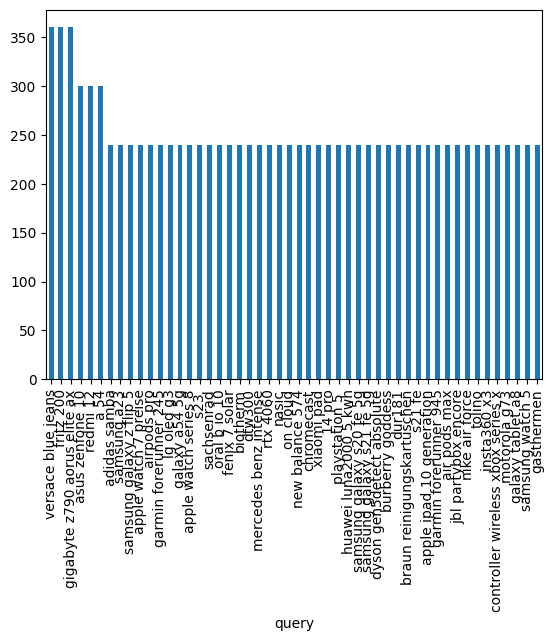

In [36]:
df['query'].value_counts().head(50).plot(kind='bar')

##### The most occuring prices.

In [37]:
df['price'].value_counts()

price
999       7272
1499      5479
699       5295
1999      5099
799       4864
          ... 
5002         1
22221        1
212901       1
28458        1
25010        1
Name: count, Length: 34451, dtype: int64

<Axes: ylabel='count'>

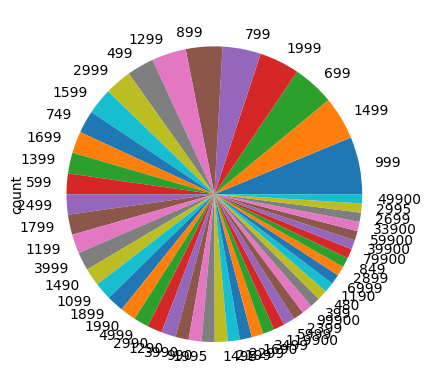

In [38]:
df['price'].value_counts().head(50).plot(kind='pie')

###### The activity of certain users.

In [39]:
df['cookie_value'].value_counts()

cookie_value
01aam42n00libf1vgs    909
01442sb34dl0xq74jz    616
01ns1k4q00kv1cbtrh    480
01a50h0000lhn4a0py    420
01fsv6pu00lkl56fs1    420
                     ... 
01ll0h0000l8wyky6h      1
01lbj0wn00leegdxri      1
01g5c3v400lgnp48dm      1
019g0h0000lb85xvot      1
013c0h0000lle2ls51      1
Name: count, Length: 12925, dtype: int64

In [40]:
df[['cookie_value', 'query']].value_counts().head(100)

cookie_value        query                
01ns1k4q00kv1cbtrh  fritz                    240
0156230p00lgv3rxl4  a 54                     240
01442sb34dl0xq74jz  versace blue jeans       240
                    mercedes benz intense    240
01ns1k4q00kv1cbtrh  fritz 200                240
                                            ... 
01mh34lo00lle5o7a8  burberry goddess         120
013r0h0000lka0nb5j  samsung galaxy a53       120
01ot0h0000lbjfryey  galaxy s 23              120
01a80h0000ll0sbkeb  nikon zfc                120
017f4eve00l5ggdkfm  huawei luna2000          120
Name: count, Length: 100, dtype: int64

In [41]:
df[df['cookie_value'] == '01442sb34dl0xq74jz']['query'].value_counts()

query
versace blue jeans       240
mercedes benz intense    240
prada l'homme            136
Name: count, dtype: int64

In [42]:
df[df['cookie_value'] == '01442sb34dl0xq74jz']['query'].value_counts()

query
versace blue jeans       240
mercedes benz intense    240
prada l'homme            136
Name: count, dtype: int64

In [43]:
df[df['cookie_value'] == '01kb0h0000lku4lwa2']['query'].value_counts()

query
lego 75336    60
lego 75301    60
lego 42110    60
lego 42145    58
lego 42144    10
Name: count, dtype: int64

###### The popularity distribution.

In [44]:
df['popularity'].value_counts()

popularity
0       285295
1        69481
2        37354
3        25986
4        18979
         ...  
757          1
848          1
4828         1
5334         1
617          1
Name: count, Length: 1978, dtype: int64

In [45]:
df[['query', 'popularity']].sort_values('popularity', ascending=False).head(100)

,query,popularity
284316,iphone 14 128 gb preis,23502
274980,iphone14 pro,23502
362843,apple iphone 13 pro max,23502
275052,apple iphone 14,23502
329096,iphone 14 128,23502
...,...,...
210664,apple iphone 10,23449
3285,apple iphone 14 128gb,23449
139184,iphone 14 pro max 128,23449
45681,apple iphone 13,23449


##### The distribution of clicks.

In [46]:
df['clicks'].value_counts().head(30)

clicks
0.0     689632
1.0      18564
2.0       6314
3.0       3076
4.0       1672
5.0        903
6.0        597
7.0        379
8.0        280
9.0        197
10.0       155
11.0       115
12.0        79
13.0        73
14.0        66
15.0        62
17.0        41
16.0        40
20.0        30
18.0        27
21.0        25
19.0        20
24.0        18
26.0        16
23.0        16
22.0        15
30.0        14
28.0        13
37.0        11
25.0        10
Name: count, dtype: int64

<Axes: ylabel='count'>

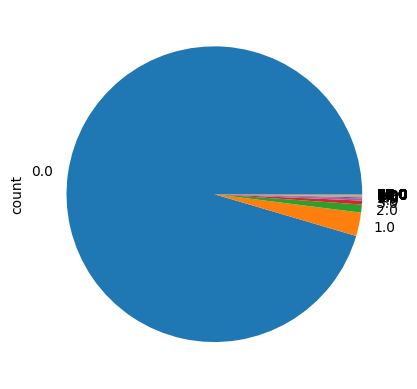

In [47]:
df['clicks'].value_counts().head(50).plot(kind='pie')

In [48]:
df[['prev_clicks', 'clicks']].corr()

,prev_clicks,clicks
prev_clicks,1.000000,0.880343
clicks,0.880343,1.000000


##### The distribution of short term bargains, bargains and discounts.

In [49]:
df['shorttermbargain'].value_counts().head(25)

shorttermbargain
0    722776
1      2513
Name: count, dtype: int64

In [50]:
df['bargain'].value_counts().head(25)

bargain
0    718399
1      6890
Name: count, dtype: int64

In [51]:
df['discount'].value_counts().head(25)

discount
0.0     718399
12.0       483
11.0       467
10.0       413
13.0       400
15.0       391
16.0       335
18.0       333
19.0       332
17.0       328
20.0       299
27.0       242
24.0       236
23.0       228
14.0       215
21.0       215
28.0       185
22.0       180
26.0       166
25.0       153
29.0       116
31.0        86
30.0        81
9.0         77
39.0        72
Name: count, dtype: int64

<Axes: ylabel='count'>

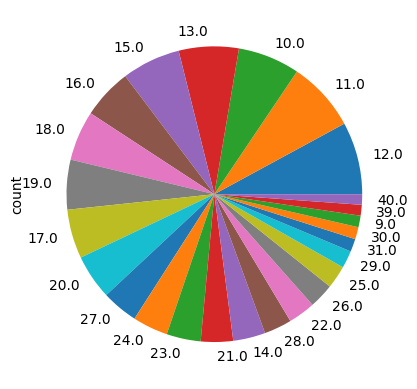

In [52]:
df[df['discount'] != 0.0]['discount'].value_counts().head(25).plot(kind='pie')

In [53]:
df[['shorttermbargain', 'bargain', 'discount']].corr()

,shorttermbargain,bargain,discount
shorttermbargain,1.000000,0.602099,0.592027
bargain,0.602099,1.000000,0.895187
discount,0.592027,0.895187,1.000000


##### Correlation of previous and current impression figures.

In [54]:
df[['prev_impressions', 'impressions']].corr()

,prev_impressions,impressions
prev_impressions,1.000000,0.863712
impressions,0.863712,1.000000


##### Target values distribution.

In [55]:
df['relevance_score'].value_counts()

relevance_score
56700      23072
37800      20998
75600      12828
39690      10326
60480       8612
           ...  
449310         1
366560         1
1143810        1
1606050        1
719680         1
Name: count, Length: 38467, dtype: int64

In [56]:
df['relevance_label'].value_counts()

relevance_label
0.0    635876
4.0     16486
1.0      7598
2.0      7353
3.0      1564
Name: count, dtype: int64

##### Product score distribution.

In [57]:
df['productscore'].value_counts()

productscore
-1.0     316555
 42.0     13945
 41.0     13626
 43.0     13488
 40.0     13302
          ...  
 6.0         31
 74.0        29
 4.0         22
 5.0          9
 3.0          2
Name: count, Length: 74, dtype: int64

##### Category ID distribution.

In [58]:
df['categoryid'].value_counts()

categoryid
19116    57228
14852    40812
25496    20003
5453     18304
3747     16312
         ...  
27746        1
26464        1
31196        1
11775        1
26416        1
Name: count, Length: 1654, dtype: int64

##### Top category distribution.

In [59]:
df['topcategory'].value_counts()

topcategory
19116    103067
25496     34256
2520      27548
3747      23768
9552      20242
          ...  
3326          2
16837         1
11473         1
21096         1
26703         1
Name: count, Length: 526, dtype: int64

##### The shop ID distribution.

In [60]:
# We can see that in 56.35% of the cases the shop ID is not available. 
#If it means there is no shop presented to the user, this has to be tackled in order to decrease the amount of such cases.
df['shopid'].value_counts()

shopid
-1.0         408734
 12041.0      70338
 9701.0       41037
 26895.0      39775
 4640.0       26756
              ...  
 318614.0         1
 329253.0         1
 313370.0         1
 320093.0         1
 329417.0         1
Name: count, Length: 1963, dtype: int64

In [61]:
df[df['shopid'] == -1.0]['query'].value_counts()

query
fritz 200          343
a 54               300
redmi 12           300
asus zenfone 10    300
s23 +              240
                  ... 
65qn95b              1
gu65cu7179           1
0195161213915        1
darsonval            1
ki87vvfe1            1
Name: count, Length: 5406, dtype: int64

In [62]:
df[df['shopid'] == -1.0].availability.value_counts()

availability
0    375743
1     21382
2      8711
5      2898
Name: count, dtype: int64

In [63]:
df[df['shopid'] == -1.0].bargain.value_counts()

bargain
0    401844
1      6890
Name: count, dtype: int64

In [64]:
df[df['shopid'] == -1.0].shorttermbargain.value_counts()

shorttermbargain
0    406221
1      2513
Name: count, dtype: int64

##### The correlation of the dataframe.

<Axes: >

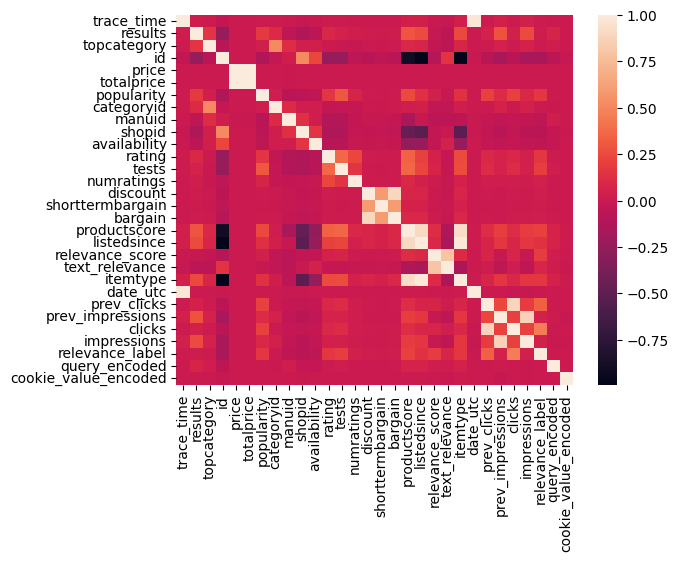

In [65]:
correlation_df = encoded_df.corr()
sns.heatmap(correlation_df, xticklabels=correlation_df.columns, yticklabels=correlation_df.columns)

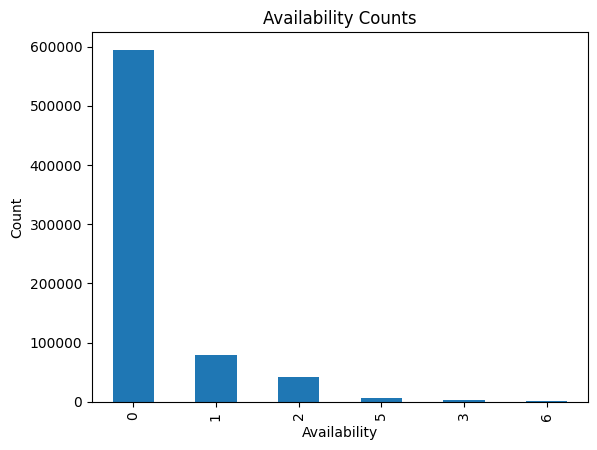

In [66]:
availability_counts = df['availability'].value_counts()
availability_counts.plot(kind='bar')
plt.xlabel('Availability')
plt.ylabel('Count')
plt.title('Availability Counts')
plt.show()

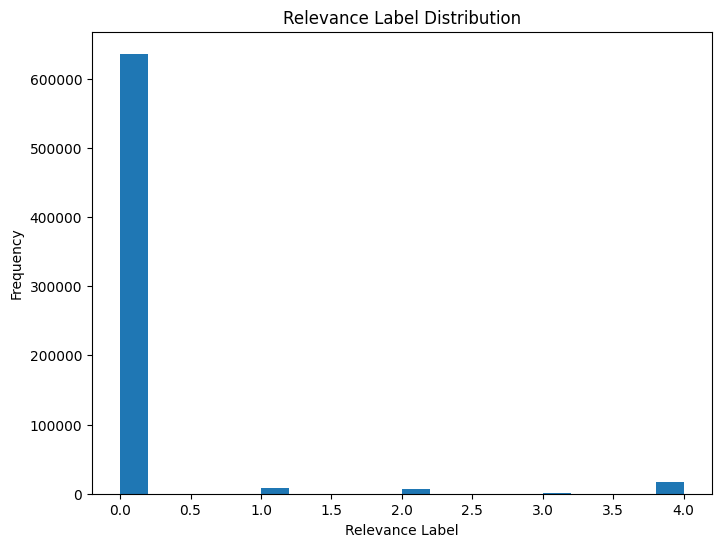

In [67]:
plt.figure(figsize=(8, 6))
plt.hist(df['relevance_label'], bins=20)
plt.title('Relevance Label Distribution')
plt.xlabel('Relevance Label')
plt.ylabel('Frequency')
plt.show()

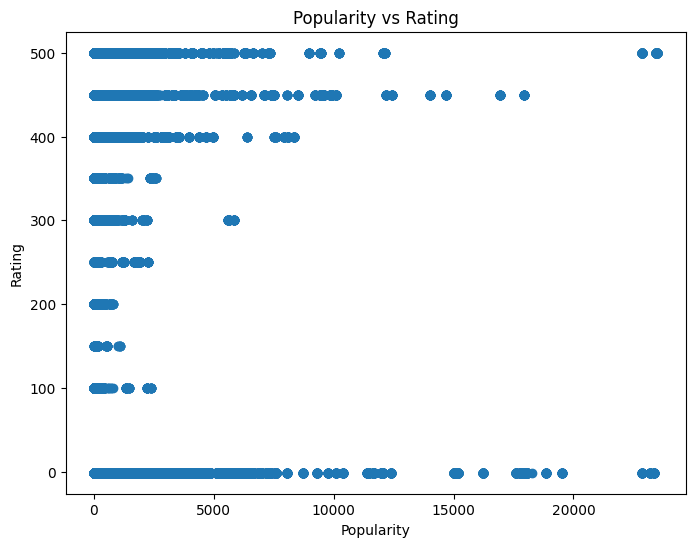

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(df['popularity'], df['rating'])
plt.title('Popularity vs Rating')
plt.xlabel('Popularity')
plt.ylabel('Rating')
plt.show()

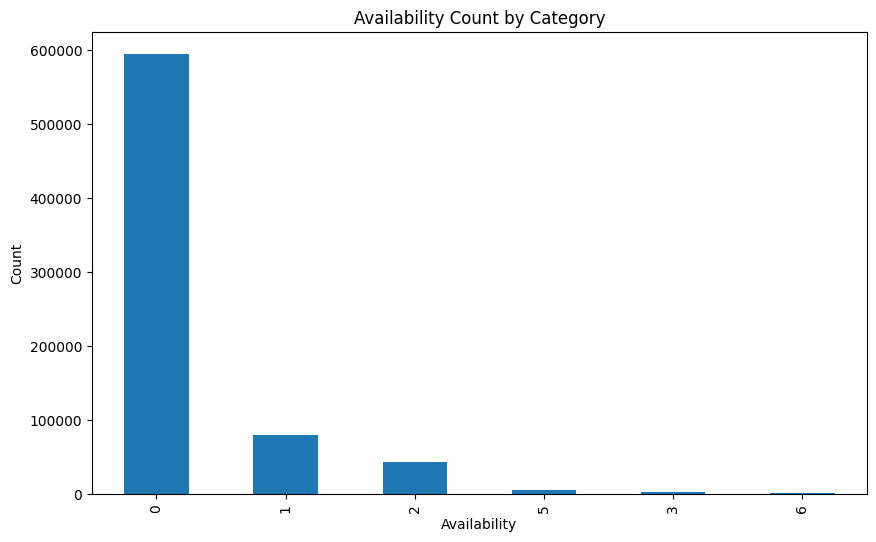

In [69]:
availability_counts = df['availability'].value_counts()
plt.figure(figsize=(10, 6))
availability_counts.plot(kind='bar')
plt.title('Availability Count by Category')
plt.xlabel('Availability')
plt.ylabel('Count')
plt.show()

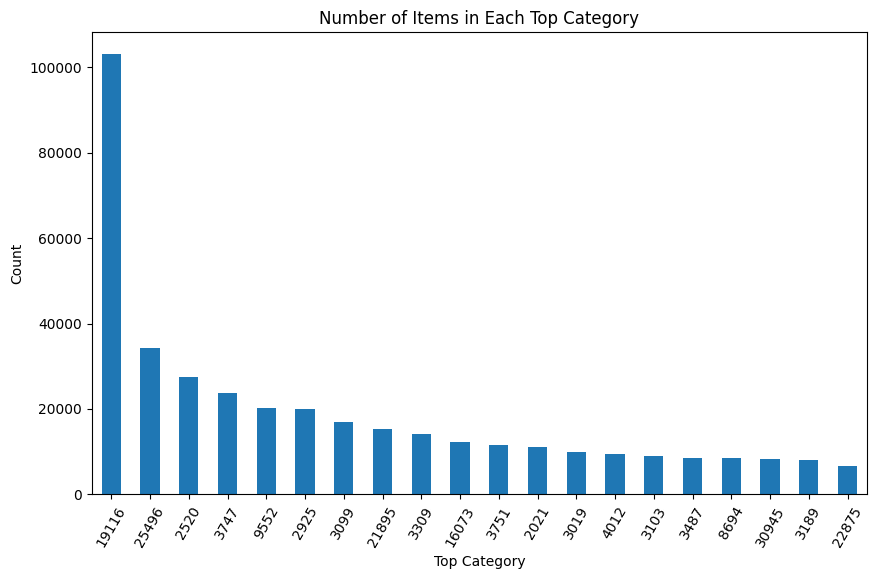

In [70]:
plt.figure(figsize=(10, 6))
category_counts = df['topcategory'].value_counts().head(20)
category_counts.plot(kind='bar')
plt.title('Number of Items in Each Top Category')
plt.xlabel('Top Category')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

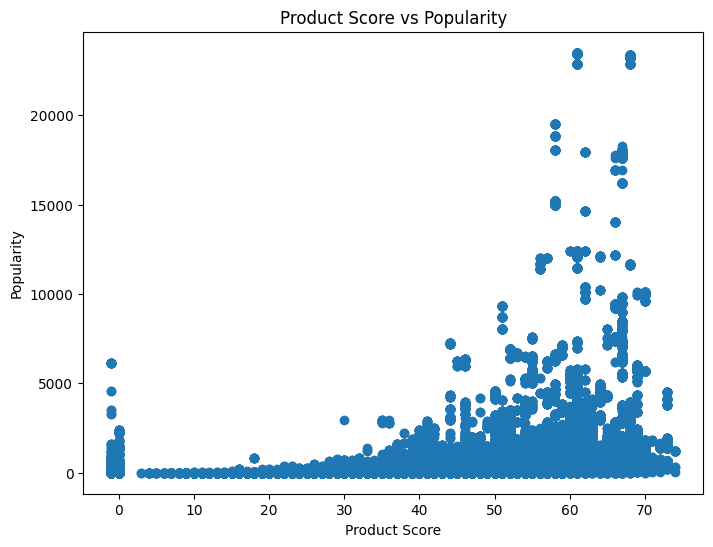

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(df['productscore'], df['popularity'])
plt.title('Product Score vs Popularity')
plt.xlabel('Product Score')
plt.ylabel('Popularity')
plt.show()

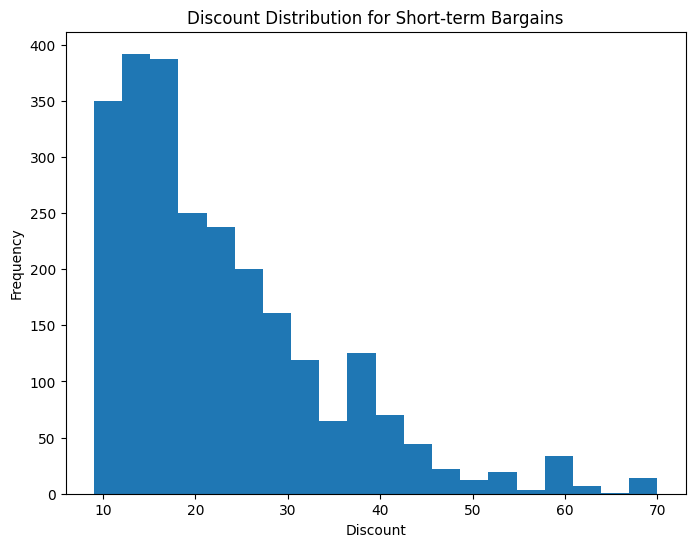

In [72]:
short_term_bargain_discounts = df[df['shorttermbargain'] == 1]['discount']
plt.figure(figsize=(8, 6))
plt.hist(short_term_bargain_discounts, bins=20)
plt.title('Discount Distribution for Short-term Bargains')
plt.xlabel('Discount')
plt.ylabel('Frequency')
plt.show()

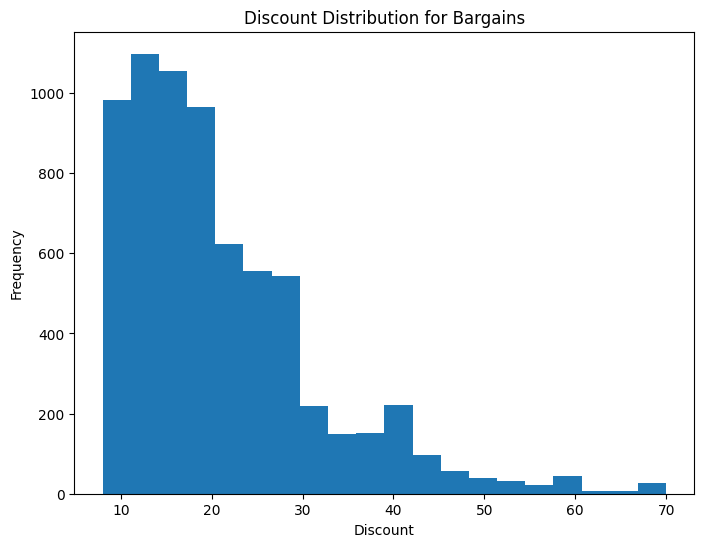

In [73]:
short_term_bargain_discounts = df[df['bargain'] == 1]['discount']
plt.figure(figsize=(8, 6))
plt.hist(short_term_bargain_discounts, bins=20)
plt.title('Discount Distribution for Bargains')
plt.xlabel('Discount')
plt.ylabel('Frequency')
plt.show()

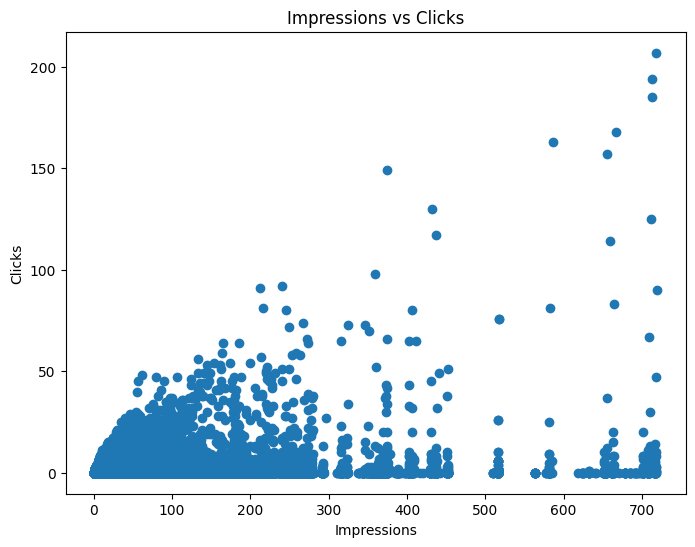

In [74]:
plt.figure(figsize=(8, 6))
plt.scatter(df['impressions'], df['clicks'])
plt.title('Impressions vs Clicks')
plt.xlabel('Impressions')
plt.ylabel('Clicks')
plt.show()

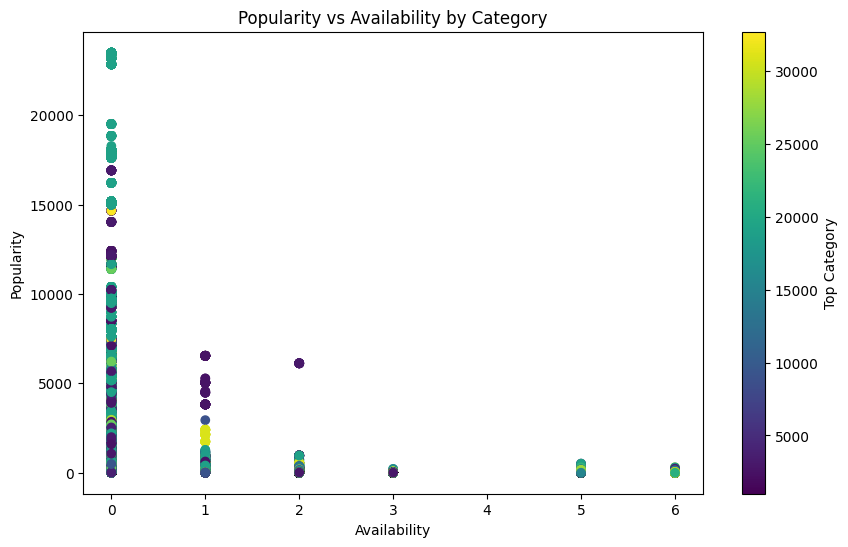

In [75]:
plt.figure(figsize=(10, 6))
plt.scatter(df['availability'], df['popularity'], c=df['topcategory'], cmap='viridis')
plt.title('Popularity vs Availability by Category')
plt.xlabel('Availability')
plt.ylabel('Popularity')
plt.colorbar(label='Top Category')
plt.show()

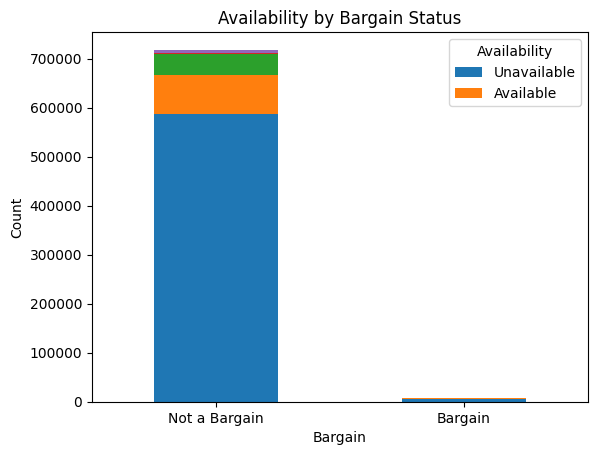

In [76]:
availability_by_bargain = df.groupby(['bargain', 'availability']).size().unstack()
availability_by_bargain.plot(kind='bar', stacked=True)
plt.title('Availability by Bargain Status')
plt.xlabel('Bargain')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not a Bargain', 'Bargain'], rotation=0)
plt.legend(title='Availability', labels=['Unavailable', 'Available'])
plt.show()

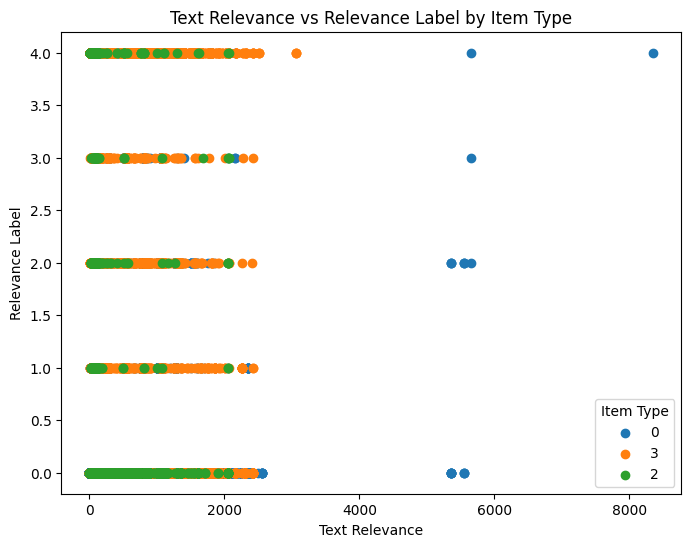

In [77]:
plt.figure(figsize=(8, 6))
for item_type in df['itemtype'].unique():
    data = df[df['itemtype'] == item_type]
    plt.scatter(data['text_relevance'], data['relevance_label'], label=item_type)
plt.title('Text Relevance vs Relevance Label by Item Type')
plt.xlabel('Text Relevance')
plt.ylabel('Relevance Label')
plt.legend(title='Item Type')
plt.show()

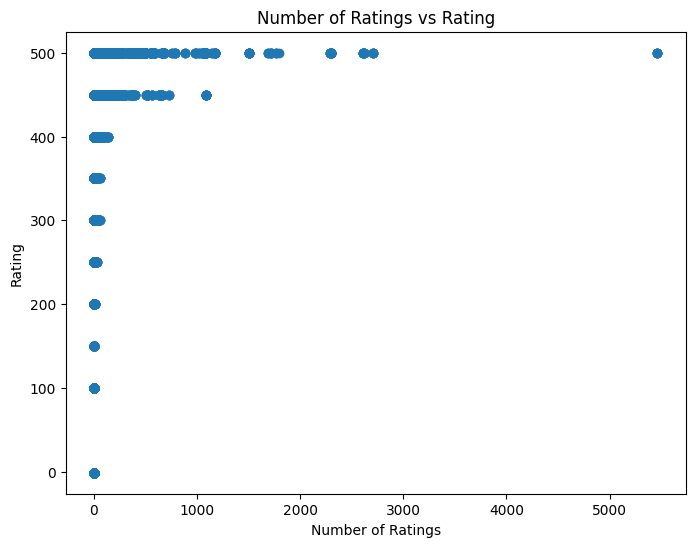

In [78]:
plt.figure(figsize=(8, 6))
plt.scatter(df['numratings'], df['rating'])
plt.title('Number of Ratings vs Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Rating')
plt.show()

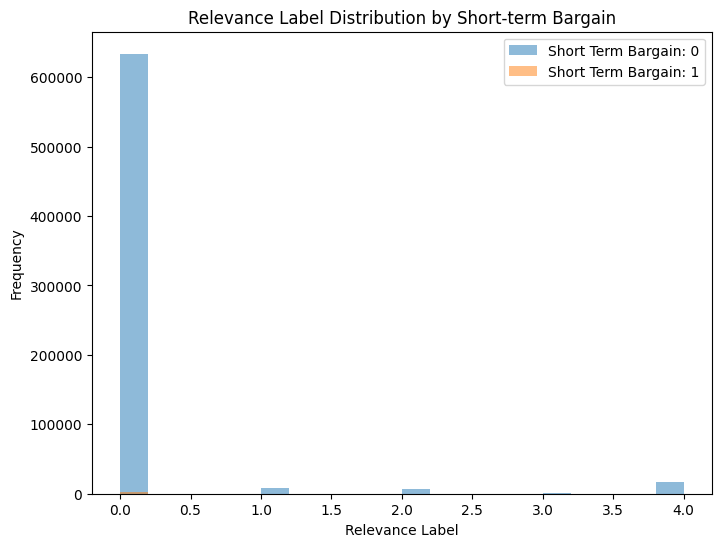

In [79]:
plt.figure(figsize=(8, 6))
for bargain_flag in df['shorttermbargain'].unique():
    data = df[df['shorttermbargain'] == bargain_flag]
    plt.hist(data['relevance_label'], alpha=0.5, bins=20, label=f'Short Term Bargain: {bargain_flag}')
plt.title('Relevance Label Distribution by Short-term Bargain')
plt.xlabel('Relevance Label')
plt.ylabel('Frequency')
plt.legend()
plt.show()

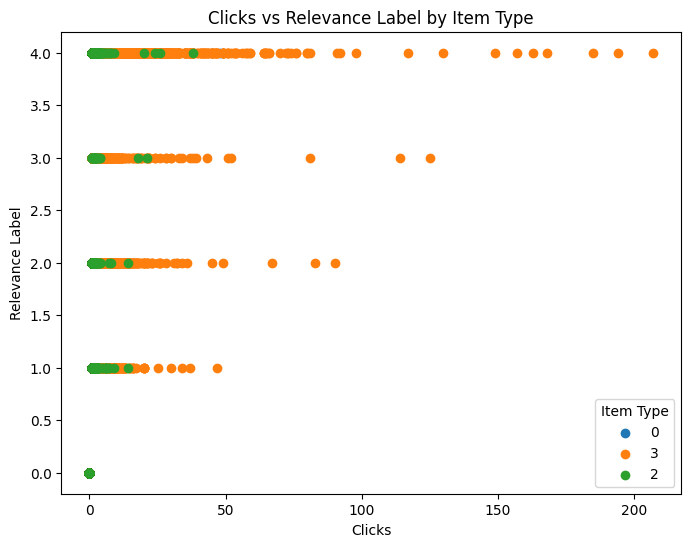

In [80]:
plt.figure(figsize=(8, 6))
for item_type in df['itemtype'].unique():
    data = df[df['itemtype'] == item_type]
    plt.scatter(data['clicks'], data['relevance_label'], label=item_type)
plt.title('Clicks vs Relevance Label by Item Type')
plt.xlabel('Clicks')
plt.ylabel('Relevance Label')
plt.legend(title='Item Type')
plt.show()